<a href="https://colab.research.google.com/github/AgaMiko/pixel_character_generator/blob/master/notebooks/6_DCGAN_and_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN + AE - Pixel character generation
Author: Agnieszka Mikołajczyk https://github.com/AgaMiko

We seperatly train Generative Adversarial Network and Autoencoder. We use GAN to generate images and Autoencoder to get better quality.

Link to github: https://github.com/AgaMiko/100-days-of-code

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random

In [0]:
# Set random seed for reproducibility
manualSeed = '123'
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


# Load dataset
Dataset can be download here: [github.com/agamiko/pixel_character_generator](https://github.com/AgaMiko/pixel_character_generator/)


In [0]:
from google.colab import files
uploaded = files.upload()
!unzip -q data.zip #uzipping dataset

Saving data.zip to data.zip


In [0]:
dataroot = "."

workers = 2 # Number of workers for dataloader
batch_size = 100 
image_size = 64

channels = 3

latent_size = 40
condition_size = 10
feature_map_size = 64
num_epochs = 350

beta1 = 0.5
ngpu = 1

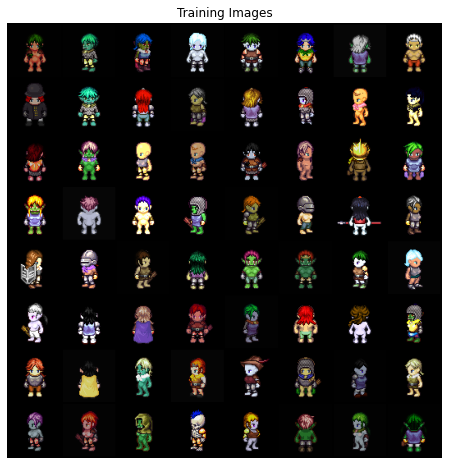

In [0]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot+'/data',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Define autoencoder architecture


In [0]:
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
 
            nn.Conv2d(channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(feature_map_size * 8, feature_map_size, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.LeakyReLU(0.2),
        )

        self.fc_class = nn.Sequential(
            nn.Linear(feature_map_size,latent_size),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.main(input)
        x = x.view(x.size(0),-1)
        x = self.fc_class(x)
        return x


In [0]:

class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu


        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(),
            nn.ConvTranspose2d( feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(),
            nn.ConvTranspose2d( feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, embedding):
      embedding = embedding.view(embedding.size(0),embedding.size(1),1,1)
      reconstructed_output = self.main(embedding)
      return reconstructed_output

In [0]:
class Autoencoder(nn.Module):
  def __init__(self, ngpu):
    super(Autoencoder,self).__init__()

    self.encoder = Encoder(ngpu).to(device)
    self.decoder = Decoder(ngpu).to(device)

  def forward(self, input, mode = 'train'):
    if mode == 'train':
      x = self.encoder(input)
      return self.decoder(x)

    if mode == 'generate':
      return self.decoder(input)

autoencoder = Autoencoder(ngpu)

print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Dropout(p=0.2, inplace=False)
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): Dropout(p=0.2, inplace=False)
      (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): LeakyReLU(negative_slope=0.2)
      (13): Conv2d(512, 64, kernel_size=(4, 4), stride=(

# Train autoencoder

In [0]:
# Training Loop

# Initialize BCELoss function
criterion = nn.MSELoss()

eps = 1e-10
lr=1e-4
optimizer = optim.Adam(autoencoder.parameters(), lr=lr, betas=(beta1, 0.999))

# Lists to keep track of progress
img_list = []
iters = 0
losses=[]
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        
        autoencoder.zero_grad()
        image = data[0].to(device)
        b_size = image.size(0)
        
        reconstructed_image = autoencoder(image).view(-1)

        err = criterion(reconstructed_image.view(image.size())+eps, image)
        err.backward()
        
        optimizer.step()
       
        # Output training stats
        if i % 50 == 0:
            print('[{0}/{1}][{2}/{3}] \t Loss: {4}'.format(epoch, num_epochs, i, len(dataloader), err.item()))

        # Save Losses for plotting later
        losses.append(err.item())

        # # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = autoencoder(fixed_noise,data[1].long().to(device)).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    lr *= 0.995
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr, betas=(beta1, 0.999))


Starting Training Loop...
[0/350][0/37] 	 Loss: 1.0063378810882568
[1/350][0/37] 	 Loss: 0.25136563181877136
[2/350][0/37] 	 Loss: 0.14525647461414337
[3/350][0/37] 	 Loss: 0.08944682031869888
[4/350][0/37] 	 Loss: 0.07473606616258621
[5/350][0/37] 	 Loss: 0.05344478785991669
[6/350][0/37] 	 Loss: 0.04868157207965851
[7/350][0/37] 	 Loss: 0.044267211109399796
[8/350][0/37] 	 Loss: 0.03628816083073616
[9/350][0/37] 	 Loss: 0.03737826272845268
[10/350][0/37] 	 Loss: 0.03480485826730728
[11/350][0/37] 	 Loss: 0.03215435892343521
[12/350][0/37] 	 Loss: 0.0320705771446228
[13/350][0/37] 	 Loss: 0.03516216203570366
[14/350][0/37] 	 Loss: 0.030501576140522957
[15/350][0/37] 	 Loss: 0.03282969072461128
[16/350][0/37] 	 Loss: 0.031968116760253906
[17/350][0/37] 	 Loss: 0.026778215542435646
[18/350][0/37] 	 Loss: 0.028736652806401253
[19/350][0/37] 	 Loss: 0.028113724663853645
[20/350][0/37] 	 Loss: 0.03408524766564369
[21/350][0/37] 	 Loss: 0.026833344250917435
[22/350][0/37] 	 Loss: 0.03147177

No handles with labels found to put in legend.


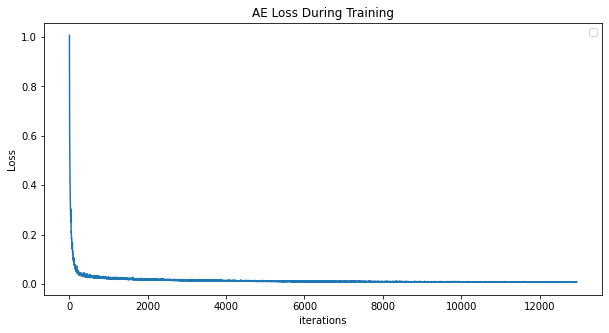

In [0]:
plt.figure(figsize=(10,5))
plt.title("AE Loss During Training")
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.Size([100, 3, 64, 64])


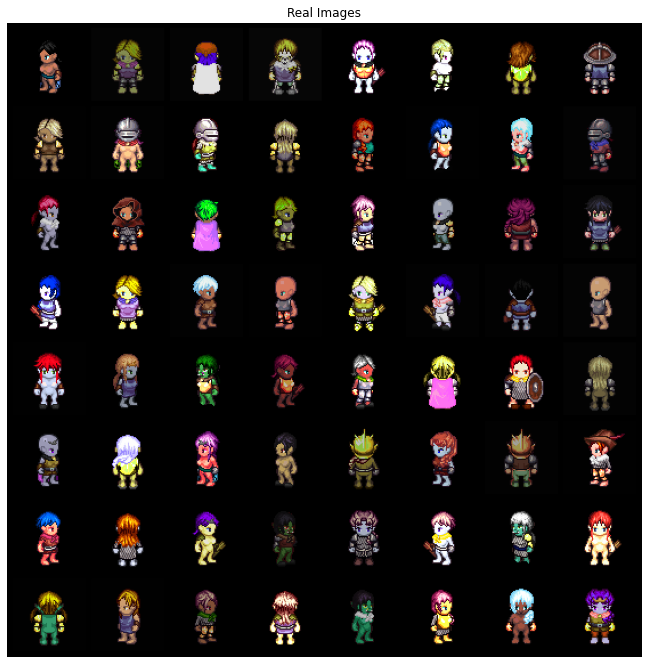

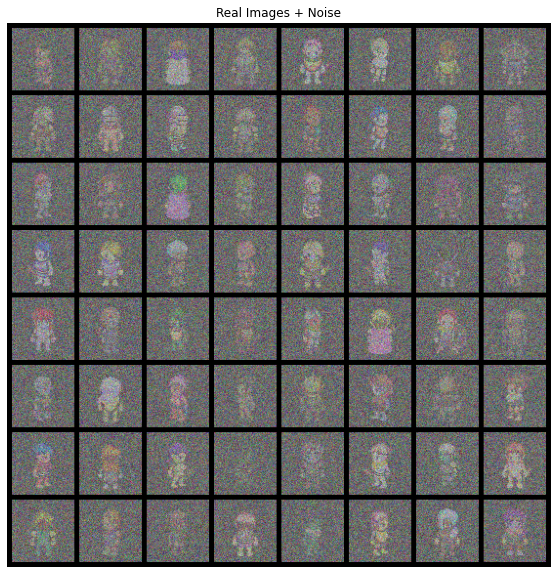

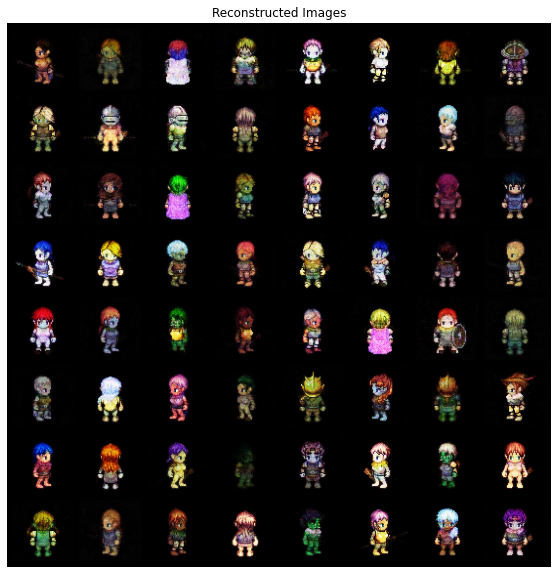

In [0]:
fake=[]
batch=4
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

with torch.no_grad():
  for k in range(1):
    fixed_noise = torch.randn(100, 3,64, 64, device=device)
    plt.figure(figsize=(10,10))
    #print(fixed_noise.size())
    print(real_batch[0].size())
    real_noised = real_batch[0].to(device)+fixed_noise*0.9
    plt.axis("off")
    plt.title("Real Images + Noise")
    plt.imshow(np.transpose(vutils.make_grid(real_noised.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    fake = autoencoder(real_noised.to(device))
    #print(fake.size())
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Reconstructed Images")
    plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
      

# Define DCGAN

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
 
            nn.Conv2d(channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2),


            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2),

        )
        self.real_fake = nn.Sequential(
            nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.conv = nn.Sequential(
            nn.Conv2d(feature_map_size * 8, feature_map_size, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.LeakyReLU(0.2),
        )

        self.fc_class = nn.Sequential(
            nn.Linear(feature_map_size,4),
            nn.Sigmoid()
        )

    def forward(self, input, mode ='train'):
      if mode == 'train':
        x = self.main(input)
        return self.real_fake(x)
      if mode == 'pretrain':
        x = self.main(input)
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.fc_class(x)
        return x

netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
  )
  (real_fake): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  

In [0]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.condition_embedding = nn.Embedding(4,condition_size)

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size+condition_size, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(),
            nn.ConvTranspose2d( feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(),
            nn.ConvTranspose2d( feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(),
            nn.ConvTranspose2d( feature_map_size, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input, condition):
      x = self.condition_embedding(condition)
      if len(x.size()) == 1:
        x = x.view(1,x.size(0),1,1)
      else:
        x = x.view(x.size(0),x.size(1),1,1)
      x = torch.cat((input, x), 1)
      return self.main(x)


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (condition_embedding): Embedding(4, 10)
  (main): Sequential(
    (0): ConvTranspose2d(50, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Train DCGAN

In [0]:
# Training Loop

# Initialize BCELoss function
criterion_ce = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
criterion_cos = nn.HingeEmbeddingLoss()

def wasserstein_loss(y_true, y_pred):
	return torch.mean(y_true * y_pred)
 
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, latent_size, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

lr_d=0.00002
lr_g=0.00008
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
num_epochs=100
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        # Soft label between 1.1 and 0.9
        label = ((1.1-0.8)*torch.rand((b_size, 1)) + 0.8).to(device)

        output = netD(real_cpu,'train').view(-1)
        
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = netG(noise,data[1].long().to(device))

        label = (0.1*torch.rand((b_size, 1))).to(device)

        output = netD(fake.detach(),'train').view(-1)
        errD_fake =  criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        output = netD(real_cpu,'pretrain')
        errD += criterion_ce(output, data[1].to(device))*0.5

        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake,'train').view(-1)
        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
       
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())


        iters += 1

Starting Training Loop...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/100][0/37]	Loss_D: 1.7824	Loss_G: 0.9845	D(x): 0.5866	D(G(z)): 0.3123 / 0.3938


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([48, 1])) that is different to the input size (torch.Size([48])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/37]	Loss_D: 1.6340	Loss_G: 1.8389	D(x): 0.7638	D(G(z)): 0.4107 / 0.1771
[2/100][0/37]	Loss_D: 1.8976	Loss_G: 1.1168	D(x): 0.4778	D(G(z)): 0.2152 / 0.3656
[3/100][0/37]	Loss_D: 1.7337	Loss_G: 1.1905	D(x): 0.6032	D(G(z)): 0.3223 / 0.3231
[4/100][0/37]	Loss_D: 1.6673	Loss_G: 1.2367	D(x): 0.6263	D(G(z)): 0.2846 / 0.3229
[5/100][0/37]	Loss_D: 2.0033	Loss_G: 0.8641	D(x): 0.4869	D(G(z)): 0.3213 / 0.4485
[6/100][0/37]	Loss_D: 1.7422	Loss_G: 1.0214	D(x): 0.6028	D(G(z)): 0.3260 / 0.3854
[7/100][0/37]	Loss_D: 1.6198	Loss_G: 1.2300	D(x): 0.6440	D(G(z)): 0.2761 / 0.3155
[8/100][0/37]	Loss_D: 1.7971	Loss_G: 1.2074	D(x): 0.6052	D(G(z)): 0.3716 / 0.3293
[9/100][0/37]	Loss_D: 1.6056	Loss_G: 1.9122	D(x): 0.7346	D(G(z)): 0.3357 / 0.1747
[10/100][0/37]	Loss_D: 1.9392	Loss_G: 1.6504	D(x): 0.7430	D(G(z)): 0.5637 / 0.2155
[11/100][0/37]	Loss_D: 1.7817	Loss_G: 1.1336	D(x): 0.5492	D(G(z)): 0.2667 / 0.3492
[12/100][0/37]	Loss_D: 1.8081	Loss_G: 1.5730	D(x): 0.6634	D(G(z)): 0.4166 / 0.2273
[13/100][0/37

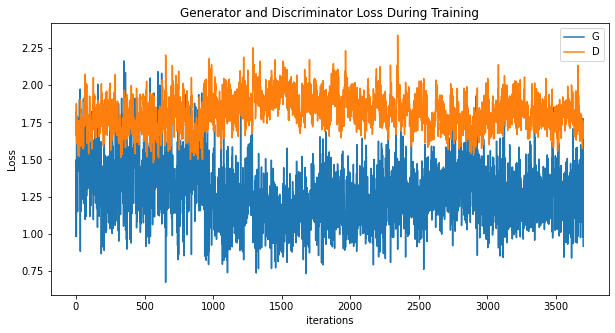

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Image generation
* Generate image with DCGAN
* Use Autoencoder on generated image to make it look more realistic

Done!

torch.Size([100, 3, 64, 64])


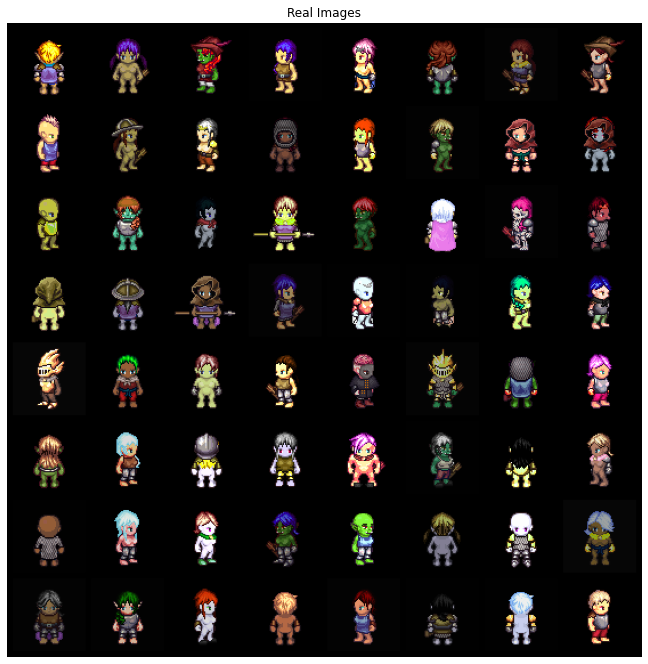

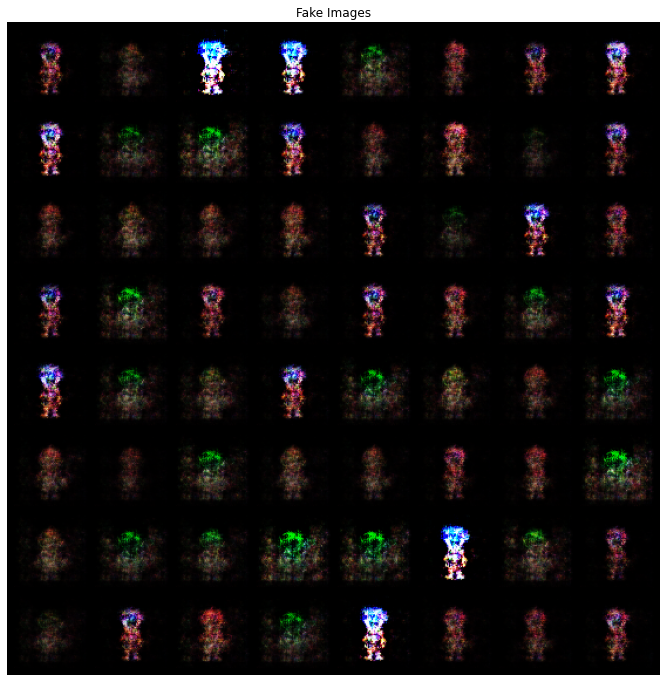

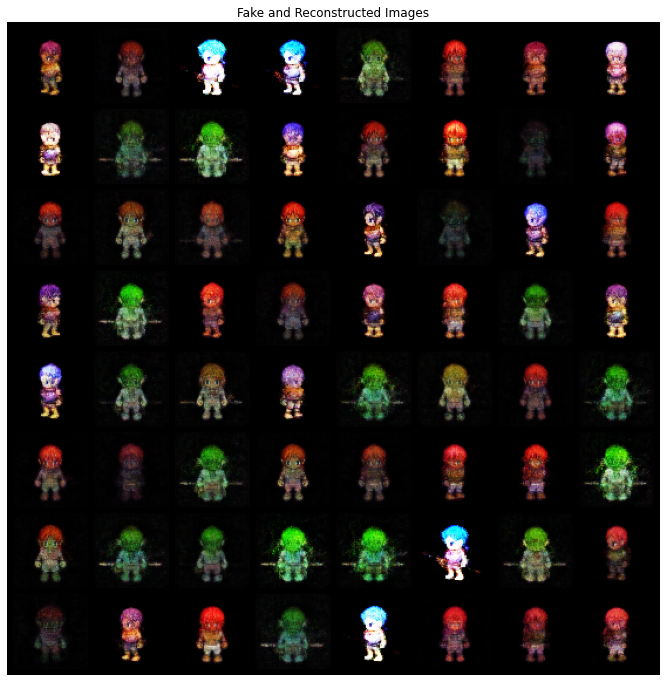

In [0]:
fake=[]
batch=100
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

with torch.no_grad():
  for k in range(1):
    fixed_noise = torch.randn(batch, latent_size, 1, 1, device=device)
    plt.figure(figsize=(12,12))
    #print(fixed_noise.size())
    print(real_batch[0].size())
    fake = netG(fixed_noise,torch.tensor([i]*batch).to(device)).detach().cpu()
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    fake = autoencoder(fake.to(device))
    #print(fake.size())
    plt.figure(figsize=(12,12))
    plt.axis("off")
    plt.title("Fake and Reconstructed Images")
    plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
      